# Redes Neurais
# Exercício 04
ELM

# 1 - Implementação da ELM

In [57]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit

class ELM(BaseEstimator, ClassifierMixin):
  def fit(self, X, y=None):
    X_b = np.hstack((np.ones((X.shape[0],1)),X))
    self.inputW = np.random.rand(X_b.shape[1], X_b.shape[1]*2)*2-1
    hidden = expit(np.matmul(X_b,self.inputW))
    self.outputW = np.matmul(np.linalg.pinv(hidden),y*2-1)
  def predict(self, X, y=None):
    resp = self.decision_function(X, y)
    if len(resp.shape)>1:
      resp = np.argmax(resp,axis=1)
    else:
      resp = resp>0
    return resp
  def decision_function(self, X, y=None):
    X_b = np.hstack((np.ones((X.shape[0],1)),X))
    hidden = expit(np.matmul(X_b,self.inputW))
    df = np.matmul(hidden,self.outputW)
    return np.tanh(df)


# 2 - Geração dos Gráficos Comparativos

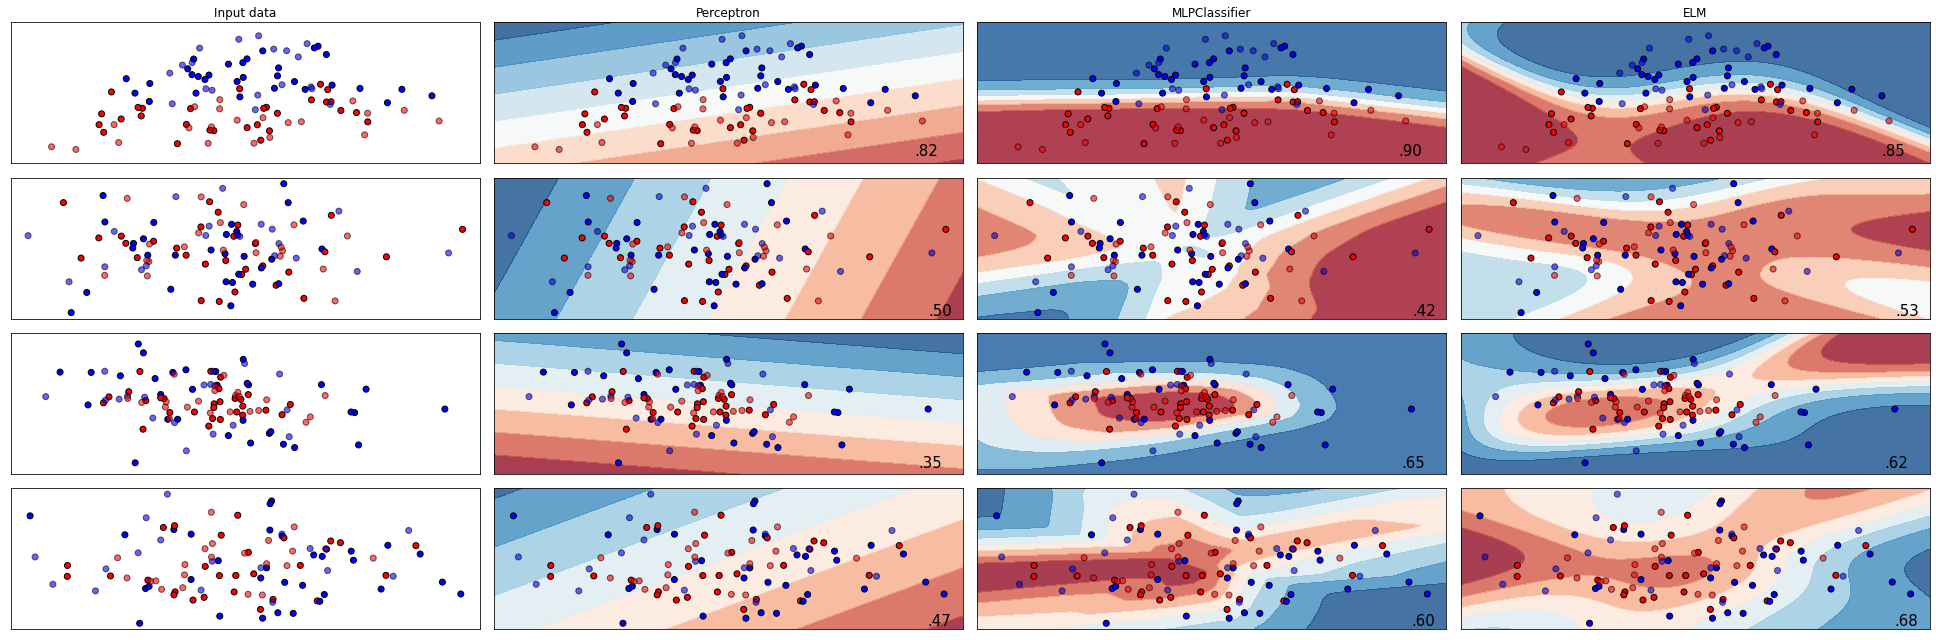

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification, make_gaussian_quantiles

from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

h = .02  # step size in the mesh

names = ["Perceptron", "MLPClassifier", "ELM"]

classifiers = [
    Perceptron(),
    MLPClassifier(),
    ELM()]


# Criação das bases
# Utilizando o make_classification
# Com mais exemplos que características
X1, y1 = make_classification(n_features=2, n_redundant=0, n_informative=2)
rng = np.random.RandomState(2)
X1 += 2 * rng.uniform(size=X1.shape)
base1 = (X1, y1)

# Com mais características que exemplos
X2, y2 = make_classification(n_features=200, n_samples=100)
rng = np.random.RandomState(2)
X2 += 2 * rng.uniform(size=X2.shape)
base2 = (X2, y2)

# Utilizando o make_classification_quantiles
# Com mais exemplos que características
X3, y3 = make_gaussian_quantiles(n_classes=2)
rng = np.random.RandomState(2)
X3 += 2 * rng.uniform(size=X3.shape)
base3 = (X3, y3)

# Com mais características que exemplos
X4, y4 = make_gaussian_quantiles(n_classes=2, n_features=200, n_samples=100)
rng = np.random.RandomState(2)
X4 += 2 * rng.uniform(size=X4.shape)
base4 = (X4, y4)

datasets_bin = [base1, base2, base3, base4]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterar as bases
for ds_cnt, ds in enumerate(datasets_bin):
    # preprocessar as bases, divisão em treino e teste
      
    X, y = ds
       
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    # aplica PCA para casos com mais de 2 características
    if X.shape[1] != 2:
      pca = PCA(n_components=2)
      pca.fit(X)
      XA = pca.transform(X)
      XA_train = pca.transform(X_train)
      XA_test = pca.transform(X_test)
    else:
      XA = X
      XA_train = X_train
      XA_test = X_test

    x_min, x_max = XA[:, 0].min() - .5, XA[:, 0].max() + .5
    y_min, y_max = XA[:, 1].min() - .5, XA[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # plota a base
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets_bin), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # plota os dados de treinamento
    ax.scatter(XA_train[:, 0], XA_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # plota os dados de teste
    ax.scatter(XA_test[:, 0], XA_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterae os classificadores
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets_bin), len(classifiers) + 1, i)
        clf.fit(XA_train, y_train)
        score = clf.score(XA_test, y_test)

        # plota os limites de decisão
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # plota com as cores
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # plota os pontos de treinamento
        ax.scatter(XA_train[:, 0], XA_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # plota os pontos de teste
        ax.scatter(XA_test[:, 0], XA_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

# 3 - Códigos do Performance Evaluator e Experimenter
Códigos utilizados na matéria de Reconhecimento de Padrões

In [61]:
from sklearn.model_selection import KFold
from scipy.sparse import coo_matrix
from sklearn.utils import shuffle
import numpy as np
import time
import statistics as st
from prettytable import PrettyTable

class PerformanceEvaluator():
  def __init__(self, X, y, f):
    X_sparse = coo_matrix(X)
    self.X, X_sparse, self.y = shuffle(X, X_sparse, y)
    self.kf = f
  def folds(self, clf):
    folds = []
    times = []
    for train_index, test_index in self.kf.split(self.X, self.y):
      t0 = time.time()
      clf.fit(self.X[train_index],self.y[train_index])
      t1 = time.time()
      folds.append(clf.score(self.X[test_index],self.y[test_index]))
      times.append(t1-t0)
    return folds, times
  def score(self, clf):
    fd, tt = self.folds(clf)
    return np.mean(fd), np.mean(tt), st.stdev(fd)#, st.variance(fd) 

class Experimenter():
  def __init__(self):
    self.datasets = []
    self.predictors = []
  def addDataset(self, dataset):
    self.datasets.append(dataset)
  def addPredictor(self, predictor):
    self.predictors.append(predictor)
  def perform(self,f):
    pt_times = PrettyTable()
    pt_mean = PrettyTable()
    pt_std = PrettyTable()
    preds = ["Dataset"]
    for predname, pred in self.predictors:
      preds.append(predname)
    pt_times.field_names = preds
    pt_mean.field_names = preds
    pt_std.field_names = preds
    for dsn, X, y in self.datasets:
      pe = PerformanceEvaluator(X,y,f)
      linha_times = [dsn]
      linha_mean = [dsn]
      linha_std = [dsn]
      for predname, pred in self.predictors:
        score, times, std = pe.score(pred)
        linha_times.append(times)
        linha_mean.append(score)
        linha_std.append(std)
      pt_times.add_row(linha_times)
      pt_mean.add_row(linha_mean)
      pt_std.add_row(linha_std)
    print("Tempos Médios")
    print(pt_times)
    print()
    print("Score")
    print(pt_mean)
    print()
    print("Desvio Padrão")
    print(pt_std)
    print()

# 4 - Geração das Tabelas Comparativas

In [62]:

perc = Perceptron()
mlp = MLPClassifier()
elm = ELM()

exp = Experimenter()
exp.addPredictor(('perceptron', perc))
exp.addPredictor(('mlpclassifier', mlp))
exp.addPredictor(('elm', elm))

exp.addDataset(('base1', base1[0], base1[1]))
exp.addDataset(('base2', base2[0], base2[1]))
exp.addDataset(('base3', base3[0], base3[1]))
exp.addDataset(('base4', base4[0], base4[1]))


kf = KFold(5)
exp.perform(f=kf)

Tempos Médios
+---------+-----------------------+---------------------+------------------------+
| Dataset |       perceptron      |    mlpclassifier    |          elm           |
+---------+-----------------------+---------------------+------------------------+
|  base1  | 0.0010512828826904296 | 0.12021398544311523 | 0.0002216815948486328  |
|  base2  |  0.001129007339477539 |  0.2135761260986328 |  0.010276079177856445  |
|  base3  | 0.0010566234588623047 | 0.12317442893981934 | 0.00022144317626953124 |
|  base4  | 0.0011515617370605469 |  0.2144930362701416 |  0.010044479370117187  |
+---------+-----------------------+---------------------+------------------------+

Score
+---------+--------------------+---------------------+--------------------+
| Dataset |     perceptron     |    mlpclassifier    |        elm         |
+---------+--------------------+---------------------+--------------------+
|  base1  | 0.8300000000000001 |  0.8799999999999999 |        0.86        |
|  base2  |

# 5 - Análise dos Resultados

Os resultados indicam que a acurácia dos classificadores MLP e ELM são similares para as bases avaliadas, enquanto o Perceptron atingiu melhor acurácia para as bases mais linearmente separáveis.

Analisando os tempos médios, verifica-se que a performance do MLP é significativamente inferior comparado aos outros classificadores. Comparando com a ELM, vemos que esta obteve acurácia similar com um desempenho superior.

Já em relação ao desvio padrão, vemos que os valores são similares para as bases 1 (geradas com "make_classification" e menos características que exemplos), 2 e 4 (geradas com "make_gaussian_quantiles", a primeira com mais características que exemplos e a segunda o inverso). Para a base 3 (gerada com o "make_guassian_quantiles" e menos características que exemplos) o devio padrão foi maior para o Perceptron.